## The linear elasticity problem

### (1) Data generating

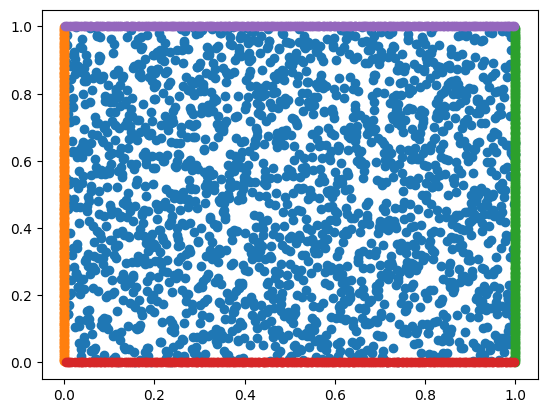

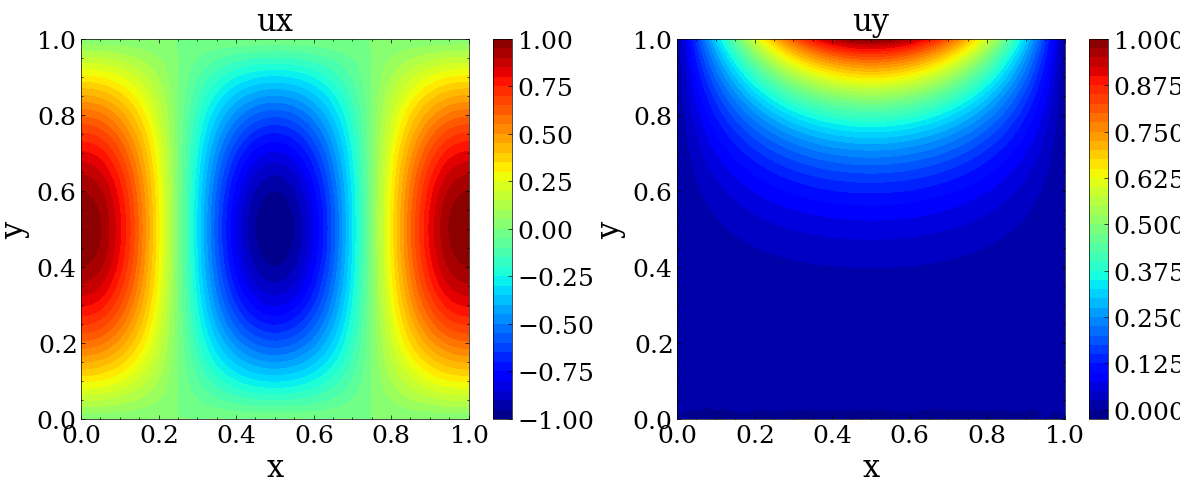

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 123
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'LinearElasticity_2d'
######################################
# Setups of the problem 
######################################
from Utils.GenPoints import Point2D
from Problems.Elasticity.LinearElasticity_2d import Problem
problem = Problem(lamda=1., mu=0.5, Q=4.)
pointGen = Point2D(x_lb=problem._lb, x_ub=problem._ub, dataType=dtype, random_seed=random_seed)
#
N_center, N_bd_each_edge = 2000, 200
xc_train, R_train = pointGen.weight_centers(n_center=N_center, R_max=1e-4, R_min=1e-4)
x_bd_train = pointGen.boundary_point(num_each_edge=N_bd_each_edge, method='hypercube')
x_test = pointGen.inner_point(num_sample_or_mesh=25, method='mesh')
#
x_lt = x_bd_train[0:N_bd_each_edge]
x_rt = x_bd_train[N_bd_each_edge:2*N_bd_each_edge]
x_bt = x_bd_train[2*N_bd_each_edge:3*N_bd_each_edge]
x_up = x_bd_train[3*N_bd_each_edge:]
#########################################
plt.figure()
plt.scatter(xc_train[...,0], xc_train[...,1])
plt.scatter(x_lt[:,0], x_lt[:,1])
plt.scatter(x_rt[:,0], x_rt[:,1])
plt.scatter(x_bt[:,0], x_bt[:,1])
plt.scatter(x_up[:,0], x_up[:,1])
plt.show()
#######################################
from Utils.PlotFigure import Plot
ux_test, uy_test = problem._ux_star(x_test), problem._uy_star(x_test)
sxx_test = problem._sxx_star(x_test)
syy_test = problem._syy_star(x_test)
sxy_test = problem._sxy_star(x_test)
Plot.show_2d_list(x_test, [ux_test, uy_test], ['ux', 'uy'], lb=0.)

### (2) Define the loss class

In [2]:
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
int_grid, _, _ = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=9, 
    dataType=dtype).get_testFun()

class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        '''
        '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_us = solver.model_dict['us']
        ######################## 
        self.int_grid = int_grid.to(self.device)
        self.n_grid = int_grid.shape[0]

    def get_values(self, x_device):
        '''
        '''
        us = self.model_us(x_device)
        ux, uy = us[...,0:1], us[...,1:2]
        sxx, syy, sxy = us[...,2:3], us[...,3:4], us[...,4:5]
        
        return ux, uy, sxx, syy, sxy
        
    def Loss_pde(self, xc=None):
        '''
        '''
        # ##################################
        xc, R = pointGen.weight_centers(n_center=200, R_max=1e-4, R_min=1e-4)
        xc, R = xc.to(self.device), R.to(self.device)
        ################################## The collocation points
        nc = xc.shape[0]
        x = self.int_grid * R + xc
        x = Variable(x.reshape(-1, 2), requires_grad=True)
        ###########################
        fx, fy = problem.fun_f(x)
        ux, uy, sxx, syy, sxy = self.get_values(x)
        #
        dux = self.solver.grad(ux, [x])[0]
        duy = self.solver.grad(uy, [x])[0]
        #
        dsxx = self.solver.grad(sxx, [x])[0]
        dsyy = self.solver.grad(syy, [x])[0]
        dsxy = self.solver.grad(sxy, [x])[0]
        ############################
        res1 = - dsxx[...,0:1] - dsxy[...,1:2] - fx
        res2 = - dsxy[...,0:1] - dsyy[...,1:2] - fy
        ##################
        Exx = dux[...,0:1]
        Eyy = duy[...,1:2]
        Exy = 0.5 * (dux[...,1:2] + duy[...,0:1])
        res3 = sxx - (2*problem.mu+problem.lamda)*Exx - problem.lamda * Eyy
        res4 = syy - (2*problem.mu+problem.lamda)*Eyy - problem.lamda * Exx
        res5 = sxy - 2*problem.mu*Exy
        #
        loss = (self.solver.getLoss(res1,  torch.zeros_like(res1))
                + self.solver.getLoss(res2,  torch.zeros_like(res2))
                + self.solver.getLoss(res3,  torch.zeros_like(res3))
                + self.solver.getLoss(res4,  torch.zeros_like(res4))
                + self.solver.getLoss(res5,  torch.zeros_like(res5))
               )
        return loss * 10.

    def Loss_bd(self):
        ''' '''
        loss = 0.
        ######### (left)
        _, uy, sxx, _, _ = self.get_values(x_lt.to(self.device))
        loss += self.solver.getLoss(uy , torch.zeros_like(uy))
        loss += self.solver.getLoss(sxx , torch.zeros_like(sxx))
        ######### (right)
        _, uy, sxx, _, _ = self.get_values(x_rt.to(self.device))
        loss += self.solver.getLoss(uy , torch.zeros_like(uy))
        loss += self.solver.getLoss(sxx , torch.zeros_like(sxx))
        ######### (bottom)
        ux, uy, _, _, _ = self.get_values(x_bt.to(self.device))
        loss += self.solver.getLoss(ux, torch.zeros_like(ux))
        loss += self.solver.getLoss(uy, torch.zeros_like(uy))
        ######### (up)
        xup = x_up.to(self.device)
        ux, _, _, syy, _ = self.get_values(xup)
        loss += self.solver.getLoss(ux, torch.zeros_like(ux))
        loss += self.solver.getLoss(
            (syy - (problem.lamda+2*problem.mu)*problem.Q*torch.sin(torch.pi * xup[...,0:1])), 
            torch.zeros_like(syy))
        return loss * 2.
        
    def Error(self):
        ''' '''
        ux = ux_test.to(self.device)
        uy = uy_test.to(self.device)
        sxx = sxx_test.to(self.device)
        syy = syy_test.to(self.device)
        sxy = sxy_test.to(self.device)
        #
        x = x_test.to(self.solver.device)
        ux_pred, uy_pred, sxx_pred, syy_pred, sxy_pred = self.get_values(x)
        #
        error = [self.solver.getError(ux_pred, ux), self.solver.getError(uy_pred, uy),
                self.solver.getError(sxx_pred, sxx), self.solver.getError(syy_pred, syy),
                self.solver.getError(sxy_pred, sxy)]
        
        return error

# #####################################
# # Define the model
# #####################################
from Solvers.PINN import PINN
#
solver = PINN.Solver(device, dtype=dtype)
us_model = solver.getModel(layers_list=[2, 40, 40, 40, 40, 40, 5], activation='Tanh', netType='FCNet')

### (3) Training and prediction

#### (3.1) Train the model

In [3]:
model_dict = {'us': us_model}
#
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR')
solver.train(LossClass, xc_train, batch_size_in=int(xc_train.shape[0]/100), epochs=1000, 
             **{'save_path':f'saved_models/'})

  1%|▌                                                       | 10/1000 [00:14<23:22,  1.42s/it]

Epoch:10 Time:14.5599, loss_in:11.700072, loss_bd:3.907756
    l2_err:[0.46110454201698303, 0.3059445023536682, 0.1179163008928299, 0.12590502202510834, 0.589777410030365], 
    lr:[0.001]


  2%|█                                                       | 20/1000 [00:28<23:04,  1.41s/it]

Epoch:20 Time:28.6949, loss_in:10.024612, loss_bd:2.262771
    l2_err:[0.3124760687351227, 0.4039488732814789, 0.0860389992594719, 0.10151681303977966, 0.4147457778453827], 
    lr:[0.001]


  3%|█▋                                                      | 30/1000 [00:42<22:48,  1.41s/it]

Epoch:30 Time:42.8067, loss_in:6.254920, loss_bd:1.618203
    l2_err:[0.23470395803451538, 0.35039082169532776, 0.0878906399011612, 0.09325689822435379, 0.3287927806377411], 
    lr:[0.001]


  4%|██▏                                                     | 40/1000 [00:56<22:35,  1.41s/it]

Epoch:40 Time:56.9386, loss_in:6.831753, loss_bd:1.236905
    l2_err:[0.19594430923461914, 0.2871340811252594, 0.06981924921274185, 0.061213526874780655, 0.27733588218688965], 
    lr:[0.001]


  5%|██▊                                                     | 50/1000 [01:11<22:20,  1.41s/it]

Epoch:50 Time:71.0575, loss_in:7.980764, loss_bd:1.183508
    l2_err:[0.17111539840698242, 0.23145684599876404, 0.06892915070056915, 0.05651216208934784, 0.23975926637649536], 
    lr:[0.001]


  6%|███▎                                                    | 60/1000 [01:25<22:05,  1.41s/it]

Epoch:60 Time:85.1624, loss_in:8.078908, loss_bd:1.077615
    l2_err:[0.14743883907794952, 0.21299292147159576, 0.06309742480516434, 0.0532200001180172, 0.2149873673915863], 
    lr:[0.001]


  7%|███▉                                                    | 70/1000 [01:39<21:53,  1.41s/it]

Epoch:70 Time:99.2885, loss_in:6.379227, loss_bd:0.852180
    l2_err:[0.14244791865348816, 0.19794590771198273, 0.05461829528212547, 0.042677391320466995, 0.18683554232120514], 
    lr:[0.001]


  8%|████▍                                                   | 80/1000 [01:53<21:38,  1.41s/it]

Epoch:80 Time:113.4052, loss_in:5.660655, loss_bd:0.856041
    l2_err:[0.1261226236820221, 0.17881491780281067, 0.04977841675281525, 0.03756409138441086, 0.1763688176870346], 
    lr:[0.001]


  9%|█████                                                   | 90/1000 [02:07<21:23,  1.41s/it]

Epoch:90 Time:127.5051, loss_in:7.082543, loss_bd:0.764901
    l2_err:[0.1157868430018425, 0.16071557998657227, 0.045090556144714355, 0.030172767117619514, 0.1638820767402649], 
    lr:[0.001]


 10%|█████▌                                                 | 100/1000 [02:21<21:08,  1.41s/it]

Epoch:100 Time:141.6060, loss_in:7.109547, loss_bd:0.772003
    l2_err:[0.1065688356757164, 0.15349619090557098, 0.04441281035542488, 0.03453117981553078, 0.14068469405174255], 
    lr:[0.001]


 11%|██████                                                 | 110/1000 [02:35<20:55,  1.41s/it]

Epoch:110 Time:155.7069, loss_in:6.177095, loss_bd:0.783461
    l2_err:[0.09485958516597748, 0.1330205500125885, 0.039819005876779556, 0.029447700828313828, 0.13794222474098206], 
    lr:[0.001]


 12%|██████▌                                                | 120/1000 [02:49<20:41,  1.41s/it]

Epoch:120 Time:169.8137, loss_in:7.506154, loss_bd:0.620783
    l2_err:[0.08526377379894257, 0.12341132014989853, 0.03487113118171692, 0.025682836771011353, 0.11731556057929993], 
    lr:[0.001]


 13%|███████▏                                               | 130/1000 [03:03<20:27,  1.41s/it]

Epoch:130 Time:183.9186, loss_in:4.249260, loss_bd:0.612724
    l2_err:[0.07625875622034073, 0.12204424291849136, 0.03318282589316368, 0.026029203087091446, 0.11015518754720688], 
    lr:[0.001]


 14%|███████▋                                               | 140/1000 [03:18<20:12,  1.41s/it]

Epoch:140 Time:198.0185, loss_in:5.195248, loss_bd:0.662268
    l2_err:[0.06630229204893112, 0.09589750319719315, 0.031124195083975792, 0.026043007150292397, 0.09688415378332138], 
    lr:[0.001]


 15%|████████▎                                              | 150/1000 [03:32<19:58,  1.41s/it]

Epoch:150 Time:212.1193, loss_in:5.178542, loss_bd:0.699192
    l2_err:[0.06090983748435974, 0.09643810987472534, 0.02858194150030613, 0.02091679722070694, 0.08742796629667282], 
    lr:[0.001]


 16%|████████▊                                              | 160/1000 [03:46<19:45,  1.41s/it]

Epoch:160 Time:226.2343, loss_in:6.123278, loss_bd:0.610304
    l2_err:[0.053472910076379776, 0.0722976103425026, 0.023396732285618782, 0.019518360495567322, 0.08356859534978867], 
    lr:[0.001]


 17%|█████████▎                                             | 170/1000 [04:00<19:30,  1.41s/it]

Epoch:170 Time:240.3341, loss_in:4.370535, loss_bd:0.639755
    l2_err:[0.04303937777876854, 0.06639263033866882, 0.022329315543174744, 0.019624272361397743, 0.06674298644065857], 
    lr:[0.001]


 18%|█████████▉                                             | 180/1000 [04:14<19:16,  1.41s/it]

Epoch:180 Time:254.4340, loss_in:5.783189, loss_bd:0.373759
    l2_err:[0.03809468820691109, 0.052962612360715866, 0.019281458109617233, 0.011369223706424236, 0.062100138515233994], 
    lr:[0.001]


 19%|██████████▍                                            | 190/1000 [04:28<19:02,  1.41s/it]

Epoch:190 Time:268.5349, loss_in:5.413291, loss_bd:0.571354
    l2_err:[0.030578283593058586, 0.054686710238456726, 0.016513094305992126, 0.014417862519621849, 0.05452854186296463], 
    lr:[0.001]


 20%|███████████                                            | 200/1000 [04:42<18:48,  1.41s/it]

Epoch:200 Time:282.6348, loss_in:3.890985, loss_bd:0.299706
    l2_err:[0.025972643867135048, 0.03485625609755516, 0.015242968685925007, 0.01346136350184679, 0.04379093274474144], 
    lr:[0.0005]


 21%|███████████▌                                           | 210/1000 [04:56<18:33,  1.41s/it]

Epoch:210 Time:296.7377, loss_in:3.828705, loss_bd:0.315106
    l2_err:[0.024352671578526497, 0.03792000561952591, 0.014465496875345707, 0.012574844993650913, 0.04434806853532791], 
    lr:[0.0005]


 22%|████████████                                           | 220/1000 [05:10<18:19,  1.41s/it]

Epoch:220 Time:310.8415, loss_in:2.928760, loss_bd:0.290573
    l2_err:[0.021729204803705215, 0.03733164072036743, 0.013025688007473946, 0.010471872985363007, 0.043044205754995346], 
    lr:[0.0005]


 23%|████████████▋                                          | 230/1000 [05:24<18:05,  1.41s/it]

Epoch:230 Time:324.9464, loss_in:2.999086, loss_bd:0.233439
    l2_err:[0.021857595071196556, 0.0300961434841156, 0.012216927483677864, 0.009530826471745968, 0.038286831229925156], 
    lr:[0.0005]


 24%|█████████████▏                                         | 240/1000 [05:39<17:53,  1.41s/it]

Epoch:240 Time:339.0613, loss_in:2.860054, loss_bd:0.305836
    l2_err:[0.01909749023616314, 0.031069453805685043, 0.01115486677736044, 0.008157555013895035, 0.0377868115901947], 
    lr:[0.0005]


 25%|█████████████▊                                         | 250/1000 [05:53<17:37,  1.41s/it]

Epoch:250 Time:353.1622, loss_in:1.974162, loss_bd:0.200596
    l2_err:[0.016675438731908798, 0.03128507733345032, 0.010672594420611858, 0.009186629205942154, 0.035858772695064545], 
    lr:[0.0005]


 26%|██████████████▎                                        | 260/1000 [06:07<17:23,  1.41s/it]

Epoch:260 Time:367.2631, loss_in:2.987578, loss_bd:0.251369
    l2_err:[0.015649644657969475, 0.02095426619052887, 0.010440018028020859, 0.008893744088709354, 0.033843446522951126], 
    lr:[0.0005]


 27%|██████████████▊                                        | 270/1000 [06:21<17:09,  1.41s/it]

Epoch:270 Time:381.3659, loss_in:3.573951, loss_bd:0.233069
    l2_err:[0.014314800500869751, 0.018462782725691795, 0.010370377451181412, 0.008601902984082699, 0.03262297809123993], 
    lr:[0.0005]


 28%|███████████████▍                                       | 280/1000 [06:35<16:55,  1.41s/it]

Epoch:280 Time:395.4688, loss_in:3.579679, loss_bd:0.293102
    l2_err:[0.013958585448563099, 0.01996484026312828, 0.010430303402245045, 0.008951997384428978, 0.03363840654492378], 
    lr:[0.0005]


 29%|███████████████▉                                       | 290/1000 [06:49<16:41,  1.41s/it]

Epoch:290 Time:409.5729, loss_in:1.588874, loss_bd:0.190530
    l2_err:[0.012027868069708347, 0.020453182980418205, 0.00891201850026846, 0.0077652838081121445, 0.030919045209884644], 
    lr:[0.0005]


 30%|████████████████▌                                      | 300/1000 [07:03<16:27,  1.41s/it]

Epoch:300 Time:423.6736, loss_in:1.988844, loss_bd:0.158628
    l2_err:[0.011080211028456688, 0.020717967301607132, 0.009696325287222862, 0.008609374985098839, 0.030560851097106934], 
    lr:[0.0005]


 31%|█████████████████                                      | 310/1000 [07:17<15:20,  1.33s/it]

Epoch:310 Time:437.4982, loss_in:2.565854, loss_bd:0.239199
    l2_err:[0.01223784126341343, 0.017933908849954605, 0.007819383405148983, 0.0065678078681230545, 0.02964809536933899], 
    lr:[0.0005]


 32%|█████████████████▌                                     | 320/1000 [07:29<13:44,  1.21s/it]

Epoch:320 Time:449.5939, loss_in:2.434389, loss_bd:0.203848
    l2_err:[0.011456618085503578, 0.017819957807660103, 0.008611838333308697, 0.007651290390640497, 0.02850649692118168], 
    lr:[0.0005]


 33%|██████████████████▏                                    | 330/1000 [07:41<13:32,  1.21s/it]

Epoch:330 Time:461.7150, loss_in:3.357075, loss_bd:0.259387
    l2_err:[0.0123110581189394, 0.015969978645443916, 0.009105614386498928, 0.007027674000710249, 0.02844143658876419], 
    lr:[0.0005]


 34%|██████████████████▋                                    | 340/1000 [07:53<13:18,  1.21s/it]

Epoch:340 Time:473.8160, loss_in:2.502804, loss_bd:0.215500
    l2_err:[0.010951779782772064, 0.017064398154616356, 0.009646250866353512, 0.008394630625844002, 0.02787611447274685], 
    lr:[0.0005]


 35%|███████████████████▎                                   | 350/1000 [08:05<13:06,  1.21s/it]

Epoch:350 Time:485.9211, loss_in:2.361315, loss_bd:0.253257
    l2_err:[0.011096677742898464, 0.01255807839334011, 0.009796567261219025, 0.008131725713610649, 0.026755226776003838], 
    lr:[0.0005]


 36%|███████████████████▊                                   | 360/1000 [08:18<12:55,  1.21s/it]

Epoch:360 Time:498.0292, loss_in:3.008063, loss_bd:0.318683
    l2_err:[0.009503267705440521, 0.014659504406154156, 0.007875916548073292, 0.006791079882532358, 0.025965841487050056], 
    lr:[0.0005]


 37%|████████████████████▎                                  | 370/1000 [08:30<12:42,  1.21s/it]

Epoch:370 Time:510.1373, loss_in:2.624780, loss_bd:0.193308
    l2_err:[0.009475566446781158, 0.014194143936038017, 0.007825362496078014, 0.006722833961248398, 0.025573546066880226], 
    lr:[0.0005]


 38%|████████████████████▉                                  | 380/1000 [08:42<12:30,  1.21s/it]

Epoch:380 Time:522.2393, loss_in:3.148319, loss_bd:0.232647
    l2_err:[0.009438859298825264, 0.012226380407810211, 0.008007846772670746, 0.007928071543574333, 0.02525617927312851], 
    lr:[0.0005]


 39%|█████████████████████▍                                 | 390/1000 [08:54<12:19,  1.21s/it]

Epoch:390 Time:534.3587, loss_in:2.577981, loss_bd:0.188980
    l2_err:[0.010053938254714012, 0.013497001491487026, 0.008858829736709595, 0.008091900497674942, 0.024724183604121208], 
    lr:[0.0005]


 40%|██████████████████████                                 | 400/1000 [09:06<12:05,  1.21s/it]

Epoch:400 Time:546.4594, loss_in:2.541498, loss_bd:0.227241
    l2_err:[0.00870133750140667, 0.011211395263671875, 0.008808511309325695, 0.007383138407021761, 0.024126075208187103], 
    lr:[0.00025]


 41%|██████████████████████▌                                | 410/1000 [09:18<11:54,  1.21s/it]

Epoch:410 Time:558.5696, loss_in:1.619018, loss_bd:0.176971
    l2_err:[0.00942964293062687, 0.013396410271525383, 0.007391352206468582, 0.0068037183955311775, 0.024663090705871582], 
    lr:[0.00025]


 42%|███████████████████████                                | 420/1000 [09:30<11:43,  1.21s/it]

Epoch:420 Time:570.6825, loss_in:1.403736, loss_bd:0.126838
    l2_err:[0.008890315890312195, 0.01304566115140915, 0.007126192096620798, 0.006057758815586567, 0.024154260754585266], 
    lr:[0.00025]


 43%|███████████████████████▋                               | 430/1000 [09:42<11:30,  1.21s/it]

Epoch:430 Time:582.8105, loss_in:1.536935, loss_bd:0.150265
    l2_err:[0.008295886218547821, 0.013674410991370678, 0.007059581112116575, 0.006534668151289225, 0.0244136955589056], 
    lr:[0.00025]


 44%|████████████████████████▏                              | 440/1000 [09:54<11:17,  1.21s/it]

Epoch:440 Time:594.9144, loss_in:1.655257, loss_bd:0.126765
    l2_err:[0.008616340346634388, 0.012852548621594906, 0.0068555776961147785, 0.0065369983203709126, 0.024223264306783676], 
    lr:[0.00025]


 45%|████████████████████████▊                              | 450/1000 [10:07<11:05,  1.21s/it]

Epoch:450 Time:607.0122, loss_in:1.640998, loss_bd:0.175215
    l2_err:[0.008994268253445625, 0.013004790991544724, 0.007261375896632671, 0.006502173840999603, 0.02421923726797104], 
    lr:[0.00025]


 46%|█████████████████████████▎                             | 460/1000 [10:19<10:53,  1.21s/it]

Epoch:460 Time:619.1152, loss_in:1.333950, loss_bd:0.148800
    l2_err:[0.008298739790916443, 0.013278893195092678, 0.006587520707398653, 0.005861083511263132, 0.023624353110790253], 
    lr:[0.00025]


 47%|█████████████████████████▊                             | 470/1000 [10:31<10:41,  1.21s/it]

Epoch:470 Time:631.2171, loss_in:1.307835, loss_bd:0.126506
    l2_err:[0.009445734322071075, 0.012910694815218449, 0.007237893529236317, 0.006642152089625597, 0.023387109860777855], 
    lr:[0.00025]


 48%|██████████████████████████▍                            | 480/1000 [10:43<10:28,  1.21s/it]

Epoch:480 Time:643.3159, loss_in:1.319483, loss_bd:0.171144
    l2_err:[0.007566577289253473, 0.012062063440680504, 0.006616527214646339, 0.0057564363814890385, 0.023127341642975807], 
    lr:[0.00025]


 49%|██████████████████████████▉                            | 490/1000 [10:55<10:16,  1.21s/it]

Epoch:490 Time:655.4158, loss_in:1.821787, loss_bd:0.135679
    l2_err:[0.007925325073301792, 0.013650454580783844, 0.007025534752756357, 0.006398887373507023, 0.02341979555785656], 
    lr:[0.00025]


 50%|███████████████████████████▌                           | 500/1000 [11:07<10:05,  1.21s/it]

Epoch:500 Time:667.5188, loss_in:1.549989, loss_bd:0.165517
    l2_err:[0.007613820023834705, 0.011529497802257538, 0.006921323016285896, 0.006183725316077471, 0.022868461906909943], 
    lr:[0.00025]


 51%|████████████████████████████                           | 510/1000 [11:19<09:53,  1.21s/it]

Epoch:510 Time:679.6322, loss_in:1.099916, loss_bd:0.122446
    l2_err:[0.007432244718074799, 0.010716275312006474, 0.00656676571816206, 0.005831722170114517, 0.02275857888162136], 
    lr:[0.00025]


 52%|████████████████████████████▌                          | 520/1000 [11:31<09:41,  1.21s/it]

Epoch:520 Time:691.7416, loss_in:1.256857, loss_bd:0.139862
    l2_err:[0.007391082122921944, 0.012039097025990486, 0.006366328801959753, 0.005840023048222065, 0.022745275869965553], 
    lr:[0.00025]


 53%|█████████████████████████████▏                         | 530/1000 [11:43<09:29,  1.21s/it]

Epoch:530 Time:703.8675, loss_in:1.502699, loss_bd:0.115679
    l2_err:[0.008008814416825771, 0.011415228247642517, 0.006176822353154421, 0.0054356190375983715, 0.02241392619907856], 
    lr:[0.00025]


 54%|█████████████████████████████▋                         | 540/1000 [11:55<09:16,  1.21s/it]

Epoch:540 Time:715.9734, loss_in:1.521100, loss_bd:0.130585
    l2_err:[0.007406466640532017, 0.010582759976387024, 0.006169297266751528, 0.005591353867202997, 0.022236429154872894], 
    lr:[0.00025]


 55%|██████████████████████████████▎                        | 550/1000 [12:08<09:04,  1.21s/it]

Epoch:550 Time:728.0712, loss_in:1.425530, loss_bd:0.132877
    l2_err:[0.008004175499081612, 0.010889207012951374, 0.006787315476685762, 0.00610729306936264, 0.02202126383781433], 
    lr:[0.00025]


 56%|██████████████████████████████▊                        | 560/1000 [12:20<08:53,  1.21s/it]

Epoch:560 Time:740.2583, loss_in:1.564450, loss_bd:0.169533
    l2_err:[0.007486725226044655, 0.010204754769802094, 0.006464158650487661, 0.00581364706158638, 0.021535851061344147], 
    lr:[0.00025]


 57%|███████████████████████████████▎                       | 570/1000 [12:32<08:40,  1.21s/it]

Epoch:570 Time:752.3653, loss_in:0.925407, loss_bd:0.118867
    l2_err:[0.007276962511241436, 0.01078897062689066, 0.005650325678288937, 0.005088740028440952, 0.021451609209179878], 
    lr:[0.00025]


 58%|███████████████████████████████▉                       | 580/1000 [12:44<08:27,  1.21s/it]

Epoch:580 Time:764.4601, loss_in:1.198382, loss_bd:0.103870
    l2_err:[0.007293815724551678, 0.0109799113124609, 0.00589193357154727, 0.005216735880821943, 0.02119944989681244], 
    lr:[0.00025]


 59%|████████████████████████████████▍                      | 590/1000 [12:56<08:16,  1.21s/it]

Epoch:590 Time:776.5575, loss_in:1.475611, loss_bd:0.166710
    l2_err:[0.007100721821188927, 0.010116873309016228, 0.00707990163937211, 0.006218859925866127, 0.020947717130184174], 
    lr:[0.00025]


 60%|█████████████████████████████████                      | 600/1000 [13:08<08:03,  1.21s/it]

Epoch:600 Time:788.6550, loss_in:1.561483, loss_bd:0.150208
    l2_err:[0.007091278675943613, 0.01007848884910345, 0.006108365952968597, 0.0058330148458480835, 0.020996470004320145], 
    lr:[0.000125]


 61%|█████████████████████████████████▌                     | 610/1000 [13:20<07:51,  1.21s/it]

Epoch:610 Time:800.7623, loss_in:1.010407, loss_bd:0.108307
    l2_err:[0.0071913511492311954, 0.010558973997831345, 0.006233787629753351, 0.005629837047308683, 0.020814260467886925], 
    lr:[0.000125]


 62%|██████████████████████████████████                     | 620/1000 [13:32<07:39,  1.21s/it]

Epoch:620 Time:812.8602, loss_in:0.799201, loss_bd:0.104253
    l2_err:[0.006892312318086624, 0.010274677537381649, 0.005699762608855963, 0.0052215950563549995, 0.02092517912387848], 
    lr:[0.000125]


 63%|██████████████████████████████████▋                    | 630/1000 [13:44<07:27,  1.21s/it]

Epoch:630 Time:824.9739, loss_in:0.971871, loss_bd:0.097716
    l2_err:[0.006745983846485615, 0.011193491518497467, 0.006011939141899347, 0.005478564649820328, 0.020896822214126587], 
    lr:[0.000125]


 64%|███████████████████████████████████▏                   | 640/1000 [13:57<07:15,  1.21s/it]

Epoch:640 Time:837.0727, loss_in:1.000416, loss_bd:0.102728
    l2_err:[0.00694320211187005, 0.009753871709108353, 0.005888315383344889, 0.0051143537275493145, 0.020727550610899925], 
    lr:[0.000125]


 65%|███████████████████████████████████▊                   | 650/1000 [14:09<07:03,  1.21s/it]

Epoch:650 Time:849.1738, loss_in:0.895738, loss_bd:0.096612
    l2_err:[0.006830045022070408, 0.01060780230909586, 0.00567865464836359, 0.0052923052571713924, 0.020750822499394417], 
    lr:[0.000125]


 66%|████████████████████████████████████▎                  | 660/1000 [14:21<06:51,  1.21s/it]

Epoch:660 Time:861.2706, loss_in:0.662607, loss_bd:0.084995
    l2_err:[0.006921202875673771, 0.010359814390540123, 0.005674964282661676, 0.004909605719149113, 0.020588468760252], 
    lr:[0.000125]


 67%|████████████████████████████████████▊                  | 670/1000 [14:33<06:39,  1.21s/it]

Epoch:670 Time:873.3704, loss_in:1.091298, loss_bd:0.108968
    l2_err:[0.006841089576482773, 0.01096814963966608, 0.0059333802200853825, 0.005427671130746603, 0.02081945724785328], 
    lr:[0.000125]


 68%|█████████████████████████████████████▍                 | 680/1000 [14:45<06:29,  1.22s/it]

Epoch:680 Time:885.5778, loss_in:0.653983, loss_bd:0.085349
    l2_err:[0.007014019414782524, 0.009531070478260517, 0.005456204526126385, 0.005017949268221855, 0.020568009465932846], 
    lr:[0.000125]


 69%|█████████████████████████████████████▉                 | 690/1000 [14:57<06:15,  1.21s/it]

Epoch:690 Time:897.6796, loss_in:1.052911, loss_bd:0.097209
    l2_err:[0.0068536861799657345, 0.009909022599458694, 0.0057402257807552814, 0.005069855600595474, 0.020444177091121674], 
    lr:[0.000125]


 70%|██████████████████████████████████████▌                | 700/1000 [15:09<06:02,  1.21s/it]

Epoch:700 Time:909.7786, loss_in:1.000180, loss_bd:0.095698
    l2_err:[0.006520163267850876, 0.011146056465804577, 0.0056527587585151196, 0.005321637727320194, 0.020279953256249428], 
    lr:[0.000125]


 71%|███████████████████████████████████████                | 710/1000 [15:21<05:51,  1.21s/it]

Epoch:710 Time:921.8859, loss_in:0.856849, loss_bd:0.094896
    l2_err:[0.006563421804457903, 0.009955509565770626, 0.005773916374891996, 0.00521802855655551, 0.020167112350463867], 
    lr:[0.000125]


 72%|███████████████████████████████████████▌               | 720/1000 [15:33<05:39,  1.21s/it]

Epoch:720 Time:933.9985, loss_in:0.891734, loss_bd:0.085948
    l2_err:[0.0065324073657393456, 0.009255405515432358, 0.005645116791129112, 0.004961646161973476, 0.020013103261590004], 
    lr:[0.000125]


 73%|████████████████████████████████████████▏              | 730/1000 [15:46<05:26,  1.21s/it]

Epoch:730 Time:946.1245, loss_in:0.607454, loss_bd:0.083979
    l2_err:[0.006524053867906332, 0.009684286080300808, 0.005406448617577553, 0.005013522692024708, 0.02017897181212902], 
    lr:[0.000125]


 74%|████████████████████████████████████████▋              | 740/1000 [15:58<05:14,  1.21s/it]

Epoch:740 Time:958.2445, loss_in:0.686142, loss_bd:0.094553
    l2_err:[0.006688463501632214, 0.011882331222295761, 0.005819063168019056, 0.0052688815630972385, 0.02000701241195202], 
    lr:[0.000125]


 75%|█████████████████████████████████████████▎             | 750/1000 [16:10<05:02,  1.21s/it]

Epoch:750 Time:970.3549, loss_in:0.929840, loss_bd:0.103999
    l2_err:[0.006352168507874012, 0.010547083802521229, 0.005510570947080851, 0.005041300319135189, 0.019771099090576172], 
    lr:[0.000125]


 76%|█████████████████████████████████████████▊             | 760/1000 [16:22<04:50,  1.21s/it]

Epoch:760 Time:982.4625, loss_in:0.716227, loss_bd:0.089996
    l2_err:[0.006261398550122976, 0.009552398696541786, 0.005300318822264671, 0.004882704932242632, 0.01978861354291439], 
    lr:[0.000125]


 77%|██████████████████████████████████████████▎            | 770/1000 [16:34<04:38,  1.21s/it]

Epoch:770 Time:994.5727, loss_in:0.585409, loss_bd:0.086567
    l2_err:[0.0067016868852078915, 0.010444591753184795, 0.005552290938794613, 0.004919761326164007, 0.019755328074097633], 
    lr:[0.000125]


 78%|██████████████████████████████████████████▉            | 780/1000 [16:46<04:26,  1.21s/it]

Epoch:780 Time:1006.6972, loss_in:0.633392, loss_bd:0.082381
    l2_err:[0.006376428529620171, 0.010696487501263618, 0.005457011982798576, 0.005106600467115641, 0.019605161622166634], 
    lr:[0.000125]


 79%|███████████████████████████████████████████▍           | 790/1000 [16:58<04:14,  1.21s/it]

Epoch:790 Time:1018.7951, loss_in:0.722786, loss_bd:0.088550
    l2_err:[0.006235653068870306, 0.008493070490658283, 0.0054727597162127495, 0.004848497454077005, 0.019462483003735542], 
    lr:[0.000125]


 80%|████████████████████████████████████████████           | 800/1000 [17:10<04:01,  1.21s/it]

Epoch:800 Time:1030.8887, loss_in:0.936859, loss_bd:0.098196
    l2_err:[0.006501762196421623, 0.008366677910089493, 0.0054798731580376625, 0.0048500122502446175, 0.01936192810535431], 
    lr:[6.25e-05]


 81%|████████████████████████████████████████████▌          | 810/1000 [17:22<03:49,  1.21s/it]

Epoch:810 Time:1042.9867, loss_in:0.552996, loss_bd:0.075482
    l2_err:[0.006320794112980366, 0.010220613330602646, 0.005230616312474012, 0.0048943860456347466, 0.01933543011546135], 
    lr:[6.25e-05]


 82%|█████████████████████████████████████████████          | 820/1000 [17:35<03:37,  1.21s/it]

Epoch:820 Time:1055.0867, loss_in:0.517814, loss_bd:0.075259
    l2_err:[0.006534737069159746, 0.008832037448883057, 0.005423945374786854, 0.004869520198553801, 0.019288120791316032], 
    lr:[6.25e-05]


 83%|█████████████████████████████████████████████▋         | 830/1000 [17:47<03:25,  1.21s/it]

Epoch:830 Time:1067.1956, loss_in:0.545034, loss_bd:0.076319
    l2_err:[0.006127668544650078, 0.009520260617136955, 0.005193657707422972, 0.004692429210990667, 0.019208701327443123], 
    lr:[6.25e-05]


 84%|██████████████████████████████████████████████▏        | 840/1000 [17:59<03:13,  1.21s/it]

Epoch:840 Time:1079.3152, loss_in:0.765187, loss_bd:0.085558
    l2_err:[0.00621720589697361, 0.009748301468789577, 0.005334001500159502, 0.0049119689501821995, 0.019309960305690765], 
    lr:[6.25e-05]


 85%|██████████████████████████████████████████████▊        | 850/1000 [18:11<03:01,  1.21s/it]

Epoch:850 Time:1091.4303, loss_in:0.518592, loss_bd:0.074977
    l2_err:[0.006252944003790617, 0.009742491878569126, 0.005258879624307156, 0.004874007776379585, 0.019259952008724213], 
    lr:[6.25e-05]


 86%|███████████████████████████████████████████████▎       | 860/1000 [18:23<02:49,  1.21s/it]

Epoch:860 Time:1103.5432, loss_in:0.511007, loss_bd:0.074144
    l2_err:[0.006309662479907274, 0.010004469193518162, 0.005247502122074366, 0.004845095798373222, 0.01918472722172737], 
    lr:[6.25e-05]


 87%|███████████████████████████████████████████████▊       | 870/1000 [18:35<02:37,  1.21s/it]

Epoch:870 Time:1115.6513, loss_in:0.687369, loss_bd:0.074598
    l2_err:[0.006308896001428366, 0.009049990214407444, 0.005241039674729109, 0.004654239863157272, 0.01915913261473179], 
    lr:[6.25e-05]


 88%|████████████████████████████████████████████████▍      | 880/1000 [18:47<02:25,  1.21s/it]

Epoch:880 Time:1127.7563, loss_in:0.522469, loss_bd:0.074160
    l2_err:[0.006428631953895092, 0.008982587605714798, 0.005268238019198179, 0.004866810981184244, 0.019137276336550713], 
    lr:[6.25e-05]


 89%|████████████████████████████████████████████████▉      | 890/1000 [18:59<02:13,  1.21s/it]

Epoch:890 Time:1139.8669, loss_in:0.548282, loss_bd:0.077197
    l2_err:[0.006259007379412651, 0.0093945087864995, 0.00529990391805768, 0.004839519504457712, 0.019128398969769478], 
    lr:[6.25e-05]


 90%|█████████████████████████████████████████████████▌     | 900/1000 [19:11<02:01,  1.21s/it]

Epoch:900 Time:1151.9842, loss_in:0.477110, loss_bd:0.072350
    l2_err:[0.006176913157105446, 0.008982568979263306, 0.005171864293515682, 0.004766490776091814, 0.019060535356402397], 
    lr:[6.25e-05]


 91%|██████████████████████████████████████████████████     | 910/1000 [19:24<01:49,  1.21s/it]

Epoch:910 Time:1164.1001, loss_in:0.520030, loss_bd:0.072115
    l2_err:[0.0062548574060201645, 0.009122339077293873, 0.005113064777106047, 0.0046726856380701065, 0.019021140411496162], 
    lr:[6.25e-05]


 92%|██████████████████████████████████████████████████▌    | 920/1000 [19:36<01:36,  1.21s/it]

Epoch:920 Time:1176.2102, loss_in:0.527467, loss_bd:0.072335
    l2_err:[0.0062141031958162785, 0.009611662477254868, 0.0052842614240944386, 0.004863311070948839, 0.018939735367894173], 
    lr:[6.25e-05]


 93%|███████████████████████████████████████████████████▏   | 930/1000 [19:48<01:24,  1.21s/it]

Epoch:930 Time:1188.3323, loss_in:0.563913, loss_bd:0.079617
    l2_err:[0.006237683352082968, 0.009763950482010841, 0.005021220538765192, 0.004624488297849894, 0.01894252747297287], 
    lr:[6.25e-05]


 94%|███████████████████████████████████████████████████▋   | 940/1000 [20:00<01:12,  1.21s/it]

Epoch:940 Time:1200.4538, loss_in:0.606626, loss_bd:0.073570
    l2_err:[0.00636467058211565, 0.008993537165224552, 0.005355746950954199, 0.004770165309309959, 0.0188045185059309], 
    lr:[6.25e-05]


 95%|████████████████████████████████████████████████████▎  | 950/1000 [20:12<01:00,  1.21s/it]

Epoch:950 Time:1212.5636, loss_in:0.484125, loss_bd:0.072140
    l2_err:[0.005849168170243502, 0.009403935633599758, 0.005002165678888559, 0.0045645334757864475, 0.018702981993556023], 
    lr:[6.25e-05]


 96%|████████████████████████████████████████████████████▊  | 960/1000 [20:24<00:48,  1.21s/it]

Epoch:960 Time:1224.6580, loss_in:0.481260, loss_bd:0.076919
    l2_err:[0.0060778115876019, 0.009096397086977959, 0.00513998419046402, 0.004628635942935944, 0.018762432038784027], 
    lr:[6.25e-05]


 97%|█████████████████████████████████████████████████████▎ | 970/1000 [20:36<00:36,  1.21s/it]

Epoch:970 Time:1236.7613, loss_in:0.531838, loss_bd:0.070176
    l2_err:[0.006001135800033808, 0.009454780258238316, 0.005014917813241482, 0.004546990152448416, 0.018762914463877678], 
    lr:[6.25e-05]


 98%|█████████████████████████████████████████████████████▉ | 980/1000 [20:48<00:24,  1.21s/it]

Epoch:980 Time:1248.8543, loss_in:0.596658, loss_bd:0.076857
    l2_err:[0.006010971497744322, 0.009148129262030125, 0.00499002868309617, 0.004584093112498522, 0.018584365025162697], 
    lr:[6.25e-05]


 99%|██████████████████████████████████████████████████████▍| 990/1000 [21:00<00:12,  1.21s/it]

Epoch:990 Time:1260.9556, loss_in:0.563843, loss_bd:0.071469
    l2_err:[0.006032668054103851, 0.009834880009293556, 0.005055292509496212, 0.00475306436419487, 0.01860875077545643], 
    lr:[6.25e-05]


100%|██████████████████████████████████████████████████████| 1000/1000 [21:13<00:00,  1.27s/it]

Epoch:1000 Time:1273.0532, loss_in:0.460160, loss_bd:0.068685
    l2_err:[0.005978978238999844, 0.010127286426723003, 0.004955796059221029, 0.004643694031983614, 0.018646545708179474], 
    lr:[3.125e-05]
The total training time is 1273.1150


#### (3.2) Make prediction

The l2 error: ux tensor([0.0059]) uy tensor([0.0104]) sxx tensor([0.0050]) syy tensor([0.0047]) sxy tensor([0.0186])


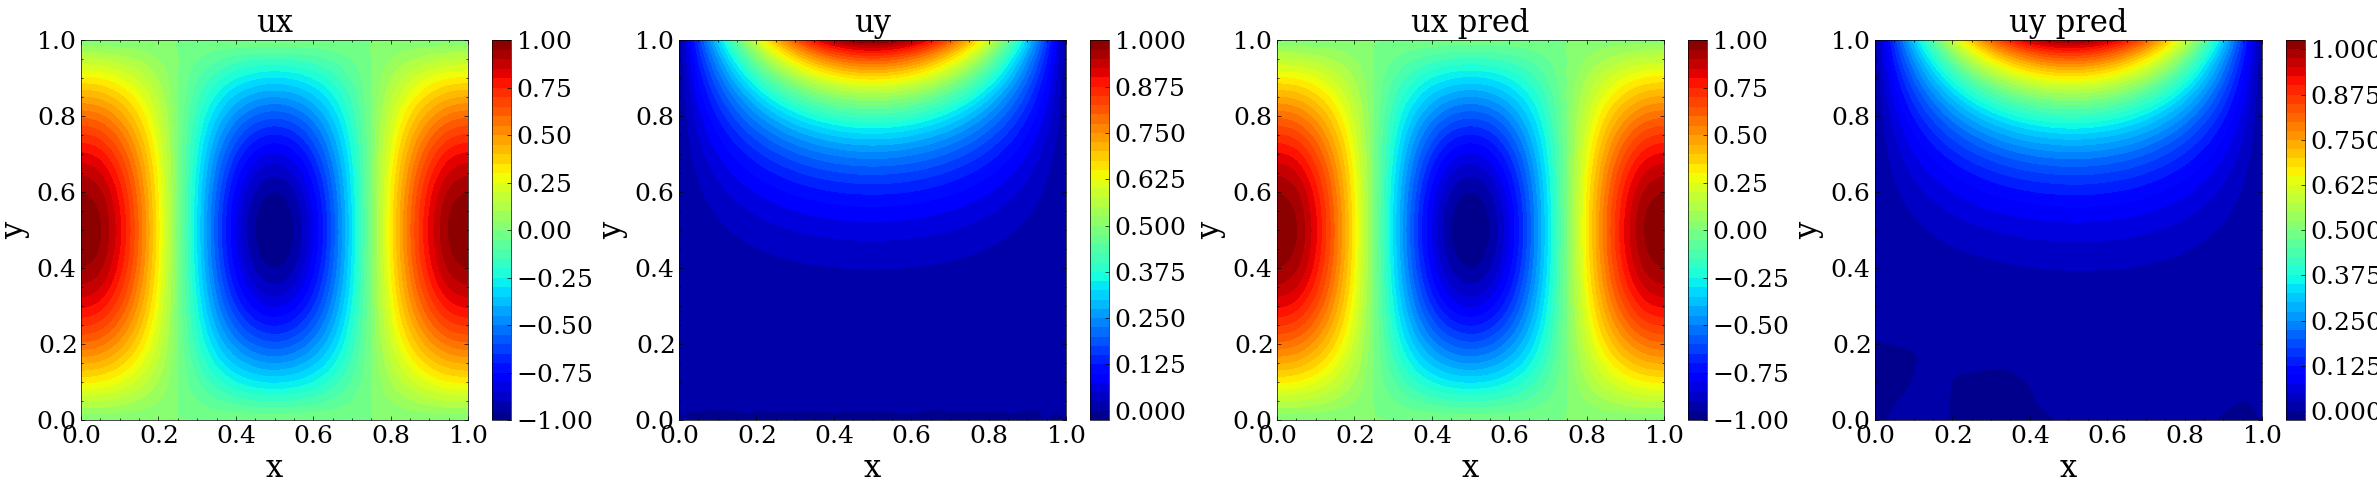

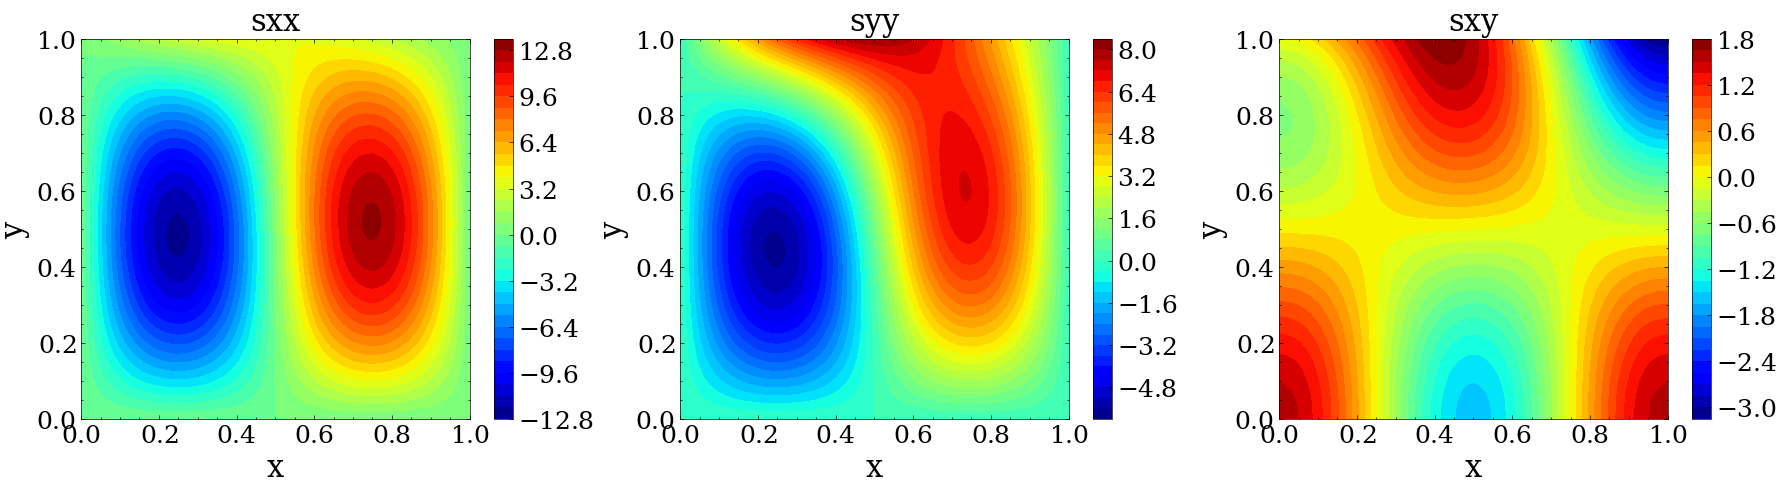

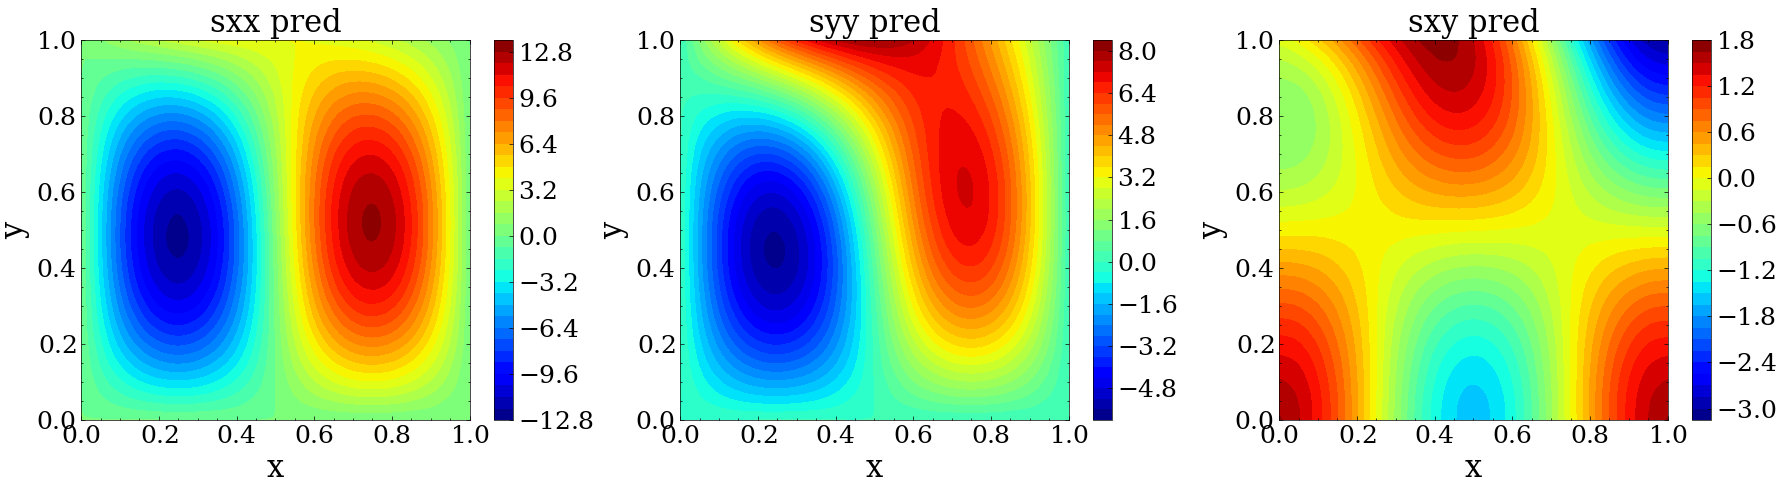

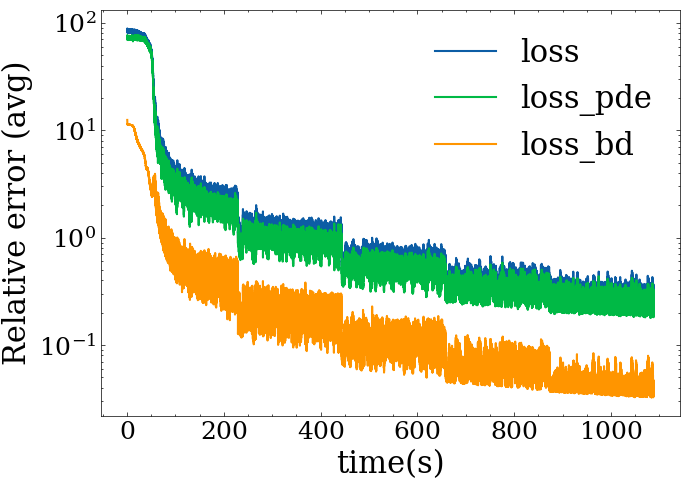

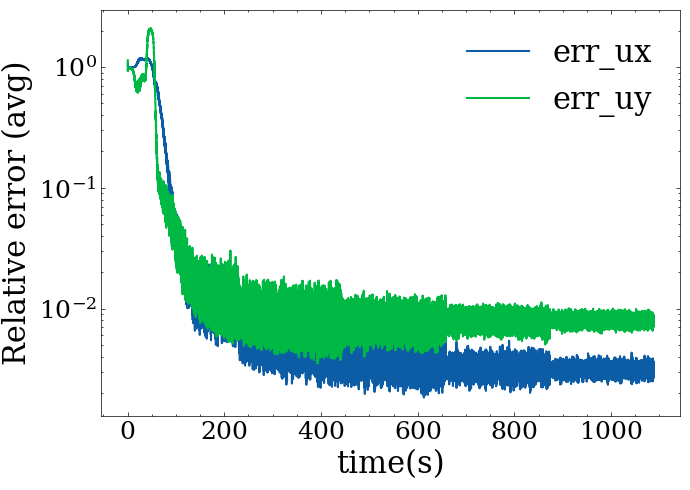

In [3]:
from Utils.PlotFigure import Plot
from Solvers.PINN import PINN
from Utils.Losses import * 
myerror = MyLoss().lp_rel
###############################
# load trained model
###############################
solver = PINN.Solver(device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/', name='model_pinn_final')

###############################
# make prediction
###############################
with torch.no_grad():
    us = model_trained['us'](x_test.to(device))
    ux_pred = us[...,0:1].detach().cpu()
    uy_pred = us[...,1:2].detach().cpu()
    sxx_pred = us[...,2:3].detach().cpu()
    syy_pred = us[...,3:4].detach().cpu()
    sxy_pred = us[...,4:5].detach().cpu()
#
print('The l2 error: ux', myerror(ux_pred, ux_test), 'uy', myerror(uy_pred, uy_test), 
      'sxx', myerror(sxx_pred, sxx_test), 'syy', myerror(syy_pred, syy_test), 'sxy', myerror(sxy_pred, sxy_test))
###############################
# show the result
###############################
# show the solution
Plot.show_2d_list(x_test, [ux_test, uy_test, ux_pred, uy_pred], ['ux', 'uy', 'ux pred', 'uy pred'])
Plot.show_2d_list(x_test, [sxx_test, syy_test, sxy_test], ['sxx', 'syy', 'sxy'])
Plot.show_2d_list(x_test, [sxx_pred, syy_pred, sxy_pred], ['sxx pred', 'syy pred', 'sxy pred'])
# show the loss
loss_saved = solver.loadLoss(path=f'saved_models/', name='loss_particlewnn')
Plot.show_error([loss_saved['time']]*3, 
                [loss_saved['loss'], loss_saved['loss_pde'], loss_saved['loss_bd']],
                ['loss', 'loss_pde', 'loss_bd'])
# show the error
Plot.show_error([loss_saved['time']]*2, [loss_saved['error'][:,0], loss_saved['error'][:,1]], ['err_ux', 'err_uy'])